In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import time
import json
import shutil
import pathlib
from pprint import pprint
from subprocess import check_output
from tqdm import tqdm

In [3]:
%%time

json_paths = sorted(pathlib.Path('../data/json').glob('*.json'))
large_json = pathlib.Path('../data/single.json')
with large_json.open('w') as fout:
    fout.write('[')
    for i, path in enumerate(tqdm(json_paths)):
        if i != 0:
            fout.write(',')
        with path.open('r') as fin:
            fout.write(fin.read())
    fout.write(']')

100%|██████████| 20000/20000 [00:01<00:00, 14118.24it/s]


CPU times: user 1.63 s, sys: 233 ms, total: 1.86 s
Wall time: 2.14 s


In [4]:
!du -sh ../solr-7.3.0/

183M	../solr-7.3.0/


In [2]:
!../solr-7.3.0/bin/solr start

*** [WARN] *** Your open file limit is currently 1024.  
 It should be set to 65000 to avoid operational disruption. 
 If you no longer wish to see this warning, set SOLR_ULIMIT_CHECKS to false in your profile or solr.in.sh
*** [WARN] ***  Your Max Processes Limit is currently 31295. 
 It should be set to 65000 to avoid operational disruption. 
 If you no longer wish to see this warning, set SOLR_ULIMIT_CHECKS to false in your profile or solr.in.sh
Waiting up to 180 seconds to see Solr running on port 8983 [|] [/] [-] [\] [|] [/] [-] [\] [|] [/] [-] [\] [|] [/] [-] [\]  
Started Solr server on port 8983 (pid=14313). Happy searching!

  

In [3]:
!../solr-7.3.0/bin/solr create -c ettoday

         To turn off: bin/solr config -c ettoday -p 8983 -property update.autoCreateFields -value false

Created new core 'ettoday'


In [4]:
%%bash
curl 'http://localhost:8983/solr/ettoday/update?commit=true' \
    --data-binary @../data/single.json \
    -H 'Content-type:application/json'

{
  "responseHeader":{
    "status":0,
    "QTime":14828}}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46.1M  100    59  100 46.1M      4  3378k  0:00:14  0:00:14 --:--:--    13

real	0m14.881s
user	0m0.014s
sys	0m0.063s


In [ ]:
!du -sh ../solr-7.3.0/

In [ ]:
# %%bash
# curl http://localhost:8983/solr/ettoday/query -d '
# {
#   "query" : "body:中文",
# }'

In [33]:
queries = np.load('../data/queries.npy')[:10000]

cmd_fmt = 'curl -s http://localhost:8983/solr/ettoday/query -d "{}"'

def solr_query(q):
    cmd = cmd_fmt.format({
        'query': 'body:{}'.format(q)
    })
    res = json.loads(check_output(cmd, shell=True).decode('utf-8'))
    return res['responseHeader']['QTime']

df = pd.DataFrame(columns=['size', 'solr_time', 'solr_real_time'])
solr_time = 0
start_time = time.time()
for i, q in enumerate(tqdm(queries)):
    solr_time += solr_query(q)
    if (i + 1) % 1000 == 0:
        data = {
            'size': i + 1, 
            'solr_time': solr_time / 1000, 
            'solr_real_time': time.time() - start_time
        }
        df = df.append(data, ignore_index=True)

df.to_csv('../data/solr_df.csv', index=False)


  1%|          | 82/10000 [00:02<04:52, 33.96it/s]Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/amoshyc/miniconda3/envs/ccu-se/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/amoshyc/miniconda3/envs/ccu-se/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/home/amoshyc/miniconda3/envs/ccu-se/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 10000/10000 [04:11<00:00, 39.77it/s]


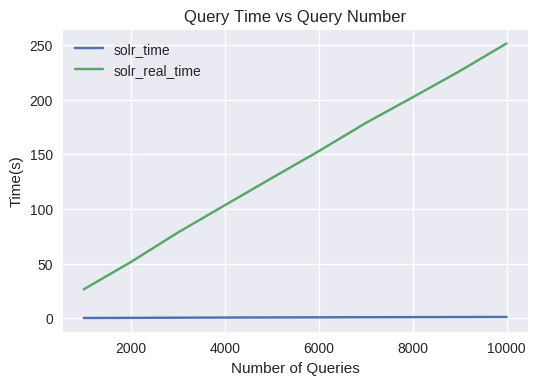

In [36]:
fig, ax = plt.subplots(dpi=100)
df.plot(ax=ax, x='size', y='solr_time')
df.plot(ax=ax, x='size', y='solr_real_time')
ax.set_ylabel('Time(s)')
ax.set_xlabel('Number of Queries')
ax.set_title('Query Time vs Query Number')
plt.show()

In [2]:
%%bash
# delete core
curl "http://localhost:8983/solr/admin/cores?action=UNLOAD&core=ettoday&deleteIndex=true&deleteDataDir=true&deleteInstanceDir=true"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (7) Failed to connect to localhost port 8983: Connection refused


In [3]:
!../solr-7.3.0/bin/solr stop -all